We desire to demonstrate a KAN on the following division:
$$ f(x_1.x_2,x_3, x_4) = \sqrt{(x_1-x_2)^2+(x_3-x_4)^2} $$

In [81]:
# Imports
import torch
import kan
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score as R2
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

#### 1. Data Generation

In [151]:
# Generate Toy Data
generator = np.random.default_rng(seed=43)
x_1 = (generator.random(10000, dtype=float)*1)
x_2 = (generator.random(10000, dtype=float)*1)
x_3 = (generator.random(10000, dtype=float)*1)
x_4 = (generator.random(10000, dtype=float)*1)
X = np.asarray([x_1, x_2, x_3, x_4]).transpose()
Y = np.sqrt((x_1-x_2)**2+(x_3-x_4)**2)


In [152]:
# Test-train split
X_TRAIN, X_TESTS, Y_TRAIN, Y_TESTS = train_test_split(X,Y, test_size=0.25, random_state=43, shuffle=True)

In [153]:
# SCALE DATA
X_Scaler = StandardScaler()
Y_Scaler = StandardScaler()

scale = True
if scale:
    X_TRAIN_S = X_Scaler.fit_transform(X_TRAIN) #
    X_TESTS_S = X_Scaler.transform(X_TESTS) #

    Y_TRAIN_S = Y_Scaler.fit_transform(Y_TRAIN.reshape(-1,1)) #
    Y_TESTS_S = Y_Scaler.transform(Y_TESTS.reshape(-1,1)) #
else:
    X_TRAIN_S = X_TRAIN #
    X_TESTS_S = X_TESTS #
    Y_TRAIN_S = Y_TRAIN #
    Y_TESTS_S = Y_TESTS #

In [154]:
# Convert to Tensors
X_TRAIN_T, X_TESTS_T = torch.from_numpy(X_TRAIN_S).float(), torch.from_numpy(X_TESTS_S).float()
Y_TRAIN_T, Y_TESTS_T = torch.from_numpy(Y_TRAIN_S).float(), torch.from_numpy(Y_TESTS_S).float()

In [155]:
# Format as DATASET
DATASET = {'train_input':X_TRAIN_T, 'test_input':X_TESTS_T, 'train_label':Y_TRAIN_T, 'test_label':Y_TESTS_T}
print(f"X Features Shape:\t({X.shape[0]} Samples) x ({X.shape[1]} Features)\t\tSplit Into: ({X_TRAIN.shape[0]}/{X_TESTS.shape[0]}) Train/Test Samples")
print(f"Y Features Shape:\t({Y.shape[0]} Samples) x ({1} Features)\t\tSplit Into: ({Y_TRAIN.shape[0]}/{Y_TESTS.shape[0]}) Train/Test Samples")

X Features Shape:	(10000 Samples) x (4 Features)		Split Into: (7500/2500) Train/Test Samples
Y Features Shape:	(10000 Samples) x (1 Features)		Split Into: (7500/2500) Train/Test Samples


#### 2. KAN Construction and Training

checkpoint directory created: ./model
saving model version 0.0


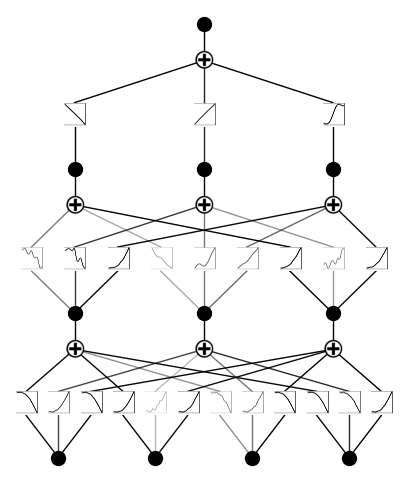

In [182]:
# Initialization
model = kan.KAN(width=[4,3,3,1], grid=8, seed=43, k=3, device='cpu')
model(DATASET['train_input'])
model.plot()
history = {"train":[],"tests":[]}

| train_loss: 1.20e-01 | test_loss: 1.07e-01 | reg: 1.44e+01 | : 100%|█| 1000/1000 [00:59<00:00, 16.


saving model version 0.1


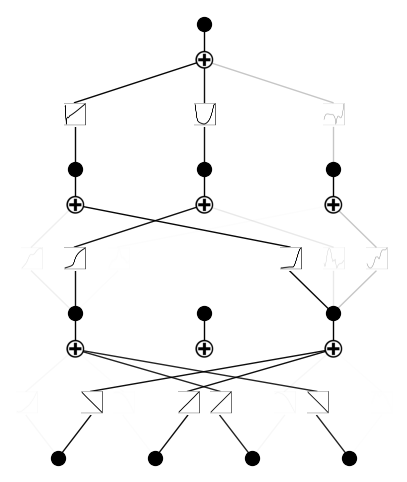

In [183]:
# Training Block
result = model.fit(DATASET, opt='Adam', steps=1000, lamb=0.01, lr=0.05)
history["train"] += result["train_loss"]
history["tests"] += result["test_loss"]
model.plot()

saving model version 0.2


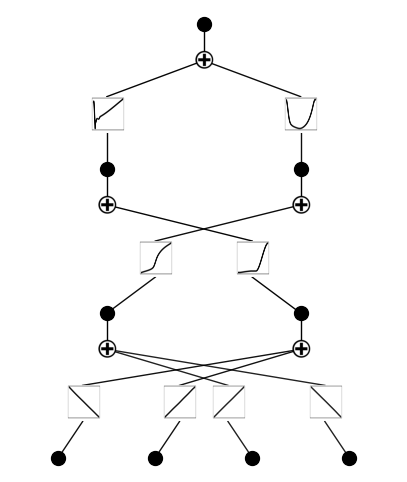

In [184]:
# Pruning Block
model = model.prune(0.15,0.15)
model.plot()

In [185]:
# Refinement Block
model.refine(8)
print()

saving model version 0.3



| train_loss: 6.07e-01 | test_loss: 6.04e-01 | reg: 1.46e+01 | : 100%|█| 200/200 [00:11<00:00, 17.88


saving model version 0.4


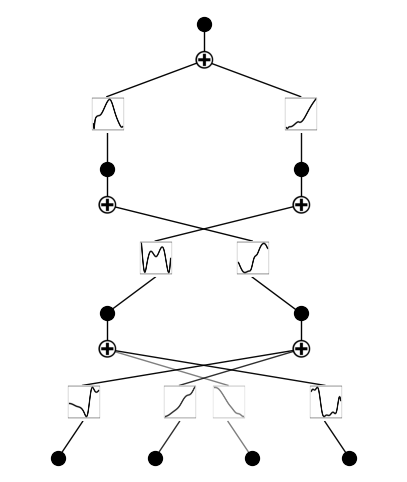

In [186]:
result = model.fit(DATASET, opt='Adam', steps=200, lamb=0.005, lr=0.2)
history["train"] += result["train_loss"]
history["tests"] += result["test_loss"]
model.plot()

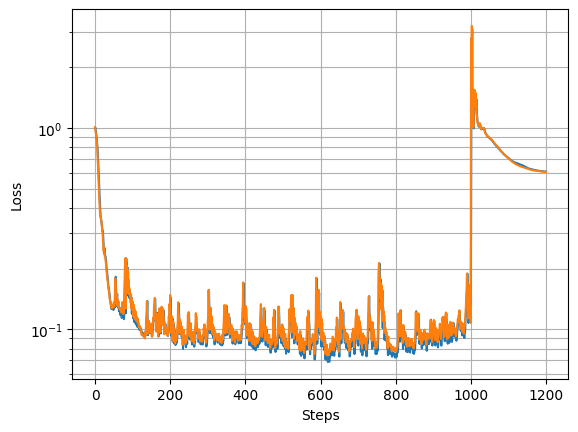

In [187]:
fig, axs = plt.subplots(1,1)
axs.plot([i for i in range(len(history["train"]))], history["train"])
axs.plot([i for i in range(len(history["tests"]))], history["tests"])
axs.set_yscale('log'); axs.set_ylabel('Loss');axs.set_xlabel("Steps"); axs.grid(visible=True, which='both')

#### 3. Results

In [188]:
# Symbolic Output
#def inverse(x):
#    return torch.div(1,x)
#kan.utils.add_symbolic('x^-1', inverse)
function_library = ['x^3','x^4','x^2','sqrt']
model.auto_symbolic(lib=function_library)

fixing (0,0,0) with 0
fixing (0,0,1) with x^2, r2=0.6604875922203064, c=2
fixing (0,1,0) with 0
fixing (0,1,1) with x^2, r2=0.9864129424095154, c=2
fixing (0,2,0) with x^2, r2=0.9863355755805969, c=2
fixing (0,2,1) with 0
fixing (0,3,0) with x^2, r2=0.7900629639625549, c=2
fixing (0,3,1) with 0
fixing (1,0,0) with 0
fixing (1,0,1) with x^2, r2=0.5088536739349365, c=2
fixing (1,1,0) with x^2, r2=0.9004746675491333, c=2
fixing (1,1,1) with 0
fixing (2,0,0) with x^2, r2=0.9186142086982727, c=2
fixing (2,1,0) with x^2, r2=0.9842061996459961, c=2
saving model version 0.5


In [189]:
from kan.utils import ex_round
ex_round(model.symbolic_formula()[0][0], 4) #type:ignore

-1.7082*(1 - 0.5991*(-0.2655*(-x_1 - 0.4148)**2 - (-0.118*x_2 - 1)**2 + 0.354)**2)**2 + 1.8631*((-0.3902*(0.4134 - x_4)**2 - 0.351*(1 - 0.2161*x_3)**2 + 1)**2 - 0.7971)**2 + 0.2611

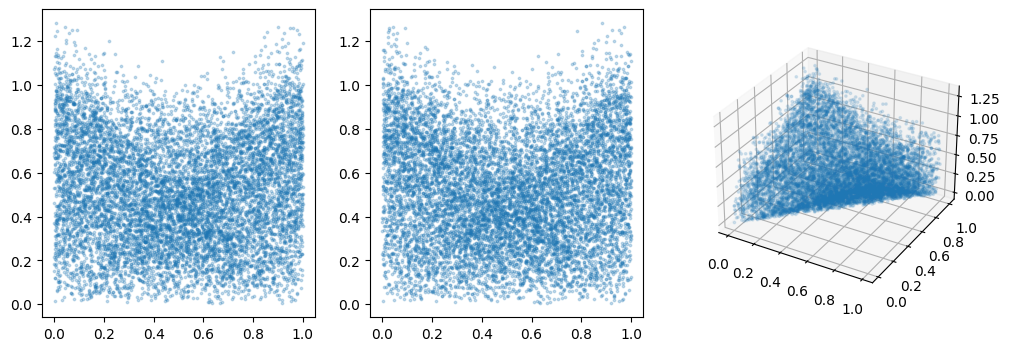

In [190]:
fig, axs = plt.subplots(1,3, figsize=(12,4))

ax=axs[0]
ax.scatter(x_1, Y, s=3, alpha=0.25)

ax=axs[1]
ax.scatter(x_2, Y, s=3, alpha=0.25)

fig.delaxes(axs[2])
ax=fig.add_subplot(1,3,3,projection='3d')
ax.scatter(x_1, x_2, Y, s=3, alpha=0.15)

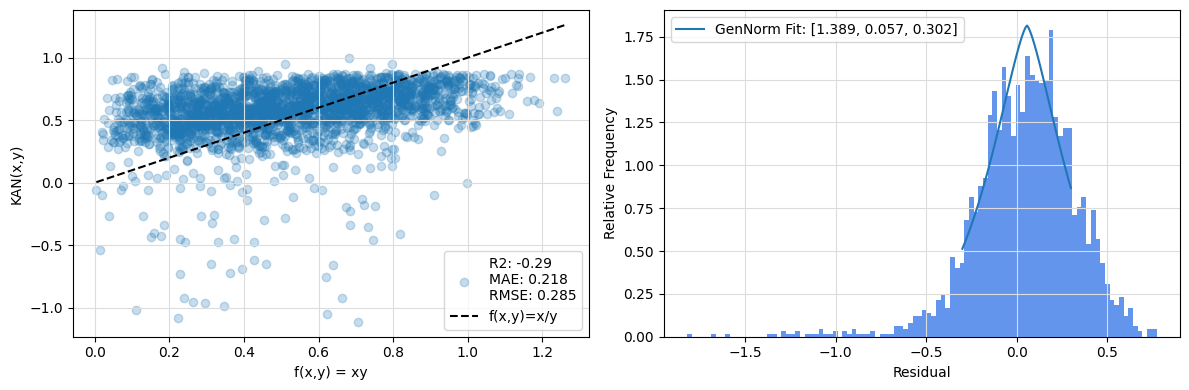

In [191]:
# --- Results - Performance
if scale:
    Y_PREDICTED = Y_Scaler.inverse_transform(model(X_TESTS_T).detach().reshape(-1,1)) # model(X_TESTS_T).detach() #
else:
    Y_PREDICTED = model(X_TESTS_T).detach()

Y_TRUE = Y_TESTS
myR2 = R2(Y_TRUE, Y_PREDICTED); myMSE = MSE(Y_TRUE, Y_PREDICTED); myMAE = MAE(Y_TRUE, Y_PREDICTED)

fig, axs = plt.subplots(1,2, figsize=(12,4))

ax=axs[0]
ax.scatter(Y_TRUE, Y_PREDICTED, alpha=0.25, label=f"R2: {round(myR2,3)}\nMAE: {round(myMAE,3)}\nRMSE: {round(myMSE**0.5,3)}")
ax.plot(np.linspace(np.min(Y_TRUE), np.max(Y_TRUE),100),np.linspace(np.min(Y_TRUE), np.max(Y_TRUE),100), color='black',ls='--', label="f(x,y)=x/y")
ax.set_xlabel("f(x,y) = xy"); ax.set_ylabel("KAN(x,y)"); ax.legend(); ax.grid(visible=True, color='gainsboro')

ax=axs[1]
residuals = Y_PREDICTED[:,0] - Y_TRUE
pdf_fit = scipy.stats.gennorm.fit(residuals)
pdf_pdf = scipy.stats.gennorm.pdf(np.linspace(-0.3,0.3,100), *pdf_fit)
ax.hist(residuals, bins=100, color='cornflowerblue', density=True)
ax.plot(np.linspace(-0.3,0.3,100), pdf_pdf, label=f'GenNorm Fit: {[round(i,3) for i in pdf_fit]}')
ax.set_xlabel("Residual"); ax.set_ylabel("Relative Frequency"); ax.grid(visible=True, color='gainsboro', label='Raw Data'); ax.legend()

fig.tight_layout()